In [39]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

import unicodedata
import string

import torch
import torch.nn as nn

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [4]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/French.txt']


In [22]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(len(all_letters), all_letters)

57 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [20]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories, all_categories)

18 ['Czech', 'Italian', 'Polish', 'Irish', 'Vietnamese', 'Portuguese', 'English', 'Korean', 'Japanese', 'Spanish', 'Chinese', 'Dutch', 'Scottish', 'Greek', 'German', 'Arabic', 'Russian', 'French']


In [12]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [18]:
for k,v in enumerate(category_lines):
    print(k,v, len(category_lines[v]))

0 Czech 519
1 Italian 709
2 Polish 139
3 Irish 232
4 Vietnamese 73
5 Portuguese 74
6 English 3668
7 Korean 94
8 Japanese 991
9 Spanish 298
10 Chinese 268
11 Dutch 297
12 Scottish 100
13 Greek 203
14 German 724
15 Arabic 2000
16 Russian 9408
17 French 277


In [30]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [25]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())
print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [32]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(output)

tensor([[-2.8549, -2.8500, -2.9369, -2.8550, -2.9516, -2.9050, -2.9302, -2.8945,
         -2.9053, -2.9796, -2.7870, -2.9404, -2.8672, -2.8492, -2.9650, -2.8320,
         -2.8824, -2.8632]], grad_fn=<LogSoftmaxBackward>)
tensor([[-0.0887,  0.0184, -0.0209, -0.0018,  0.0738,  0.0140, -0.0945,  0.0094,
          0.0215,  0.1183, -0.0545, -0.0112, -0.0531,  0.0580,  0.0484, -0.0753,
          0.0434,  0.1456, -0.0158, -0.0396,  0.0429,  0.0144, -0.0622, -0.0665,
         -0.0017,  0.0012,  0.0640,  0.0193, -0.0492,  0.0741,  0.0321, -0.0292,
         -0.0501, -0.0178, -0.0732,  0.0301,  0.0096, -0.0150, -0.0031, -0.1004,
         -0.0322, -0.0054, -0.0258,  0.1116, -0.1207, -0.0439,  0.0614,  0.0296,
          0.0545, -0.0316,  0.0909, -0.0842,  0.0163, -0.0122, -0.0465,  0.0073,
         -0.0251, -0.0895,  0.0015,  0.0134, -0.0211, -0.0219, -0.0501,  0.0565,
          0.0203,  0.0264,  0.0030, -0.0339, -0.0287, -0.0044,  0.0271, -0.0136,
         -0.0138, -0.0835, -0.0505,  0.0561,  0.02

In [33]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(categoryFromOutput(output))

('Chinese', 10)


In [36]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Bezyazykov
category = Japanese / line = Fumihiko
category = Arabic / line = Koury
category = Spanish / line = Sandoval
category = Dutch / line = Nelissen
category = Chinese / line = Lai
category = Spanish / line = Del bosque
category = Dutch / line = Leeuwenhoek
category = Arabic / line = Issa
category = Polish / line = Gomolka


In [37]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [38]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 3.0724 Kessler / German ✗ (Czech)
10000 10% (0m 26s) 1.5826 Tudorovsky / Russian ✓
15000 15% (0m 39s) 3.9335 Bezyzvestnykh / Dutch ✗ (Russian)
20000 20% (0m 51s) 0.4460 Son / Korean ✓
25000 25% (1m 5s) 0.6162 Veronesi / Italian ✓
30000 30% (1m 21s) 0.1848 Shammas / Arabic ✓
35000 35% (1m 36s) 1.7565 Meisner / German ✗ (Dutch)
40000 40% (1m 50s) 1.9473 Chin / Korean ✗ (Chinese)
45000 45% (2m 5s) 1.3956 Bock / Czech ✓
50000 50% (2m 18s) 0.4585 Dubhain / Irish ✓
55000 55% (2m 30s) 2.3104 Kava / Czech ✗ (Polish)
60000 60% (2m 42s) 0.6447 Gordeenko / Russian ✓
65000 65% (2m 53s) 1.2167 Haddad / Arabic ✓
70000 70% (3m 6s) 1.0276 Ieyoshi / Japanese ✓
75000 75% (3m 18s) 0.0177 O'Loughlin / Irish ✓
80000 80% (3m 30s) 0.8866 Sarraf / Arabic ✓
85000 85% (3m 42s) 2.0592 Winman / Polish ✗ (English)
90000 90% (3m 57s) 0.2552 Thach / Vietnamese ✓
95000 95% (4m 7s) 0.3912 Scolaidhe / Irish ✓
100000 100% (4m 21s) 1.1806 Ton / Chinese ✗ (Vietnamese)


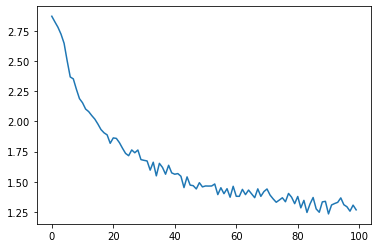

In [40]:
plt.figure()
plt.plot(all_losses)

<ipython-input-41-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-41-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


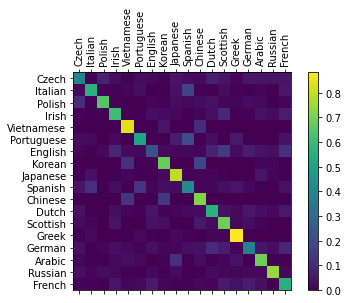

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [42]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.43) Russian
(-1.68) Czech
(-2.50) Polish

> Jackson
(-0.37) Scottish
(-1.90) English
(-2.67) Russian

> Satoshi
(-0.92) Japanese
(-1.49) Italian
(-2.13) Arabic
